# Lab 10: Anonymization Using K-Means Clustering

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In this lab we will use some traffic data from Scotland. Each record consists of a traffic measurement at a particular location and time. We will try to predict the total amount of motor vehicle traffic (all_motor_vehicles), given other features such as hour, time, year, location coordinates, type of road, etc. 

In [2]:
df = pd.read_csv('scotland-traffic.csv', parse_dates=['count_date'])

We will extract the month from the date and use that as a separate feature. We will also recode the road type. 

In [3]:
df['month'] = pd.DatetimeIndex(df['count_date']).month

In [4]:
df['road_type'] = df['road_type'] == 'Major'

We'll get rid of the records that are missing the outcome variable. And for now we'll replace all other missing values with 0. 

In [5]:
df = df[~df.all_motor_vehicles.isna()]
df.fillna(0, inplace=True)

In [6]:
df.head()

,year,count_date,hour,road_type,latitude,longitude,link_length_km,pedal_cycles,two_wheeled_motor_vehicles,buses_and_coaches,all_motor_vehicles,month
0,2005,2005-05-12,7,True,55.837029,-3.925646,8.4,0,2,10,3299,5
1,2005,2005-05-12,8,True,55.837029,-3.925646,8.4,0,4,5,2852,5
2,2005,2005-05-12,9,True,55.837029,-3.925646,8.4,0,4,18,2346,5
3,2005,2005-05-12,10,True,55.837029,-3.925646,8.4,0,10,17,2392,5
4,2005,2005-05-12,11,True,55.837029,-3.925646,8.4,0,4,12,1685,5


## Predicting Number of Motor Vehicles, Given Other Features (No Anonymization)

In our first experiment, we'll try to predict the amount of motor vehicle traffic using all of the other features, with no anonymization of the data. 

In [7]:
features = ['year', 'hour', 'month', 'latitude', 'longitude', 'link_length_km', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'buses_and_coaches', 'road_type']

X = df[features]

In [8]:
y = df['all_motor_vehicles']

We'll rescale all of the features so that they will all fall within a similar range. 

In [9]:
X = preprocessing.StandardScaler().fit_transform(X)

We'll use 2/3 of the data for training and 1/3 for testing. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

For now we'll use k-nearest neigbors regression. (yet another $k$ with yet another meaning)

This is a very simple regression model that is often effective. Basically when we want to predict the value of the outcome variable for a test example, we find its $k$ nearest neighbours in the training set and predict the average of their values. 

You could also use linear regression, or a multi-layer perceptron, or a random forest model, for example. 

In [11]:
knn = KNeighborsRegressor(n_neighbors=10)

In [12]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [13]:
preds = knn.predict(X_test)

We're going to report an evaluation metric called the R2 score (or r-squared metric). Basically a value close to 1 is good as it means the predictive model explains much of the variance in the outcome variable. 

In [14]:
r2_orig = r2_score(y_test, preds)
print('R2 Score (No Anonymization):', r2_orig)

R2 Score (No Anonymization): 0.7825568558823538


Not bad! We can compare the actual values with our predicted values. 

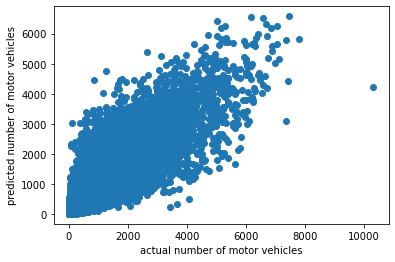

In [15]:
plt.figure()
plt.scatter(y_test, preds)
plt.xlabel('actual number of motor vehicles')
plt.ylabel('predicted number of motor vehicles')
plt.show()

# Predicting Number of Motor Vehicles (With Anonymized Data)

Now we'll try anonymizing the data using k-means clustering, and then trying the same prediction tasks on the anonymized data. 

In [24]:
from sklearn.cluster import KMeans
from sklearn import linear_model

We'll first attempt this with 20 clusters. That's a really low value for this dataset. Each cluster will end up having a large number of observations and the dataset will end up being heavily modified as a result. 

In [17]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

We'll add the cluster assignments to our original dataframe. Each record/observation has a cluster number now. 

In [18]:
df['cluster'] = kmeans.labels_
print(df.head())

   year count_date  hour  road_type   latitude  longitude  link_length_km  \
0  2005 2005-05-12     7       True  55.837029  -3.925646             8.4   
1  2005 2005-05-12     8       True  55.837029  -3.925646             8.4   
2  2005 2005-05-12     9       True  55.837029  -3.925646             8.4   
3  2005 2005-05-12    10       True  55.837029  -3.925646             8.4   
4  2005 2005-05-12    11       True  55.837029  -3.925646             8.4   

   pedal_cycles  two_wheeled_motor_vehicles  buses_and_coaches  \
0             0                           2                 10   
1             0                           4                  5   
2             0                           4                 18   
3             0                          10                 17   
4             0                           4                 12   

   all_motor_vehicles  month  cluster  
0                3299      5        7  
1                2852      5        7  
2                234

We'll create a new dataframe that stores the centroid vector for each cluster. 

In [19]:
feas_anon = [f+'_anon' for f in features]

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=feas_anon)
cluster_centers['cluster_num'] = cluster_centers.index
print(cluster_centers.head())

   year_anon  hour_anon  month_anon  latitude_anon  longitude_anon  \
0   0.182063  -0.001391    0.186400       1.720786       -2.723157   
1   0.134434  -0.032922    1.189540      -0.540352       -0.465077   
2  -0.280126   0.887330    1.279523      -0.366730       -0.140502   
3   0.957290   0.961974   -0.594705      -0.414735       -0.190133   
4   0.938547  -0.957359   -0.617074      -0.411600       -0.181090   

   link_length_km_anon  pedal_cycles_anon  two_wheeled_motor_vehicles_anon  \
0             0.013529          -0.228431                        -0.347991   
1            -0.496631          -0.111420                        -0.346156   
2             0.179067          -0.116935                         0.103294   
3            -0.495034          -0.032202                        -0.316686   
4            -0.495248          -0.095206                        -0.373647   

   buses_and_coaches_anon  road_type_anon  cluster_num  
0               -0.446483       -0.115030            

Now we'll join those two dataframes, so that we have a new dataframe which contains both the original data and the anonymized data for each row. 

In [20]:
df_merge = df.merge(cluster_centers, how='left', left_on='cluster', right_on='cluster_num')

In our second experiment, we'll use just the anonymized features. 

In [21]:
new_X = df_merge[feas_anon]
new_y = df_merge['all_motor_vehicles']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)

knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train, y_train)

preds_anon = knn.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization):', r2_anon)

R2 Score (With Anonymization): 0.4398600984628366


Our score has taken quite a hit. That's not too surprising, given that we used a very small number of clusters, resulting in an anonymized dataset in which a lot of information was lost. In the lab assignment, you'll see if you can improve this. 

# Lab Assignment

Try the following:
   - Try different number of clusters (e.g. both smaller and greater than what we tried) and anonymize the data using those clusterings. See how the prediction performance on the anonymized data changes as you change the number of clusters. Keep in mind that if you try a very large number of clusters, it may take several minutes to find a solution. 
   - Try at least one other regression model other than k-nearest neighbors and see how it performs on this prediction task, both on the original data and on the anonymized data. You could use linear regression, or a multi-layer perceptron, or another regression model of your choice. 

### Deliverables: Submit your completed notebook via Blackboard. 

In [25]:
# Greater clusters.
k = 30
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
df['cluster'] = kmeans.labels_
#print(df.head())
feas_anon = [f+'_anon' for f in features]

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=feas_anon)
cluster_centers['cluster_num'] = cluster_centers.index
#print(cluster_centers.head())
df_merge = df.merge(cluster_centers, how='left', left_on='cluster', right_on='cluster_num')
new_X = df_merge[feas_anon]
new_y = df_merge['all_motor_vehicles']
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)

lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

preds_anon = lm.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization with 100 clusters):', r2_anon)

R2 Score (With Anonymization with 100 clusters): 0.4626918920672154


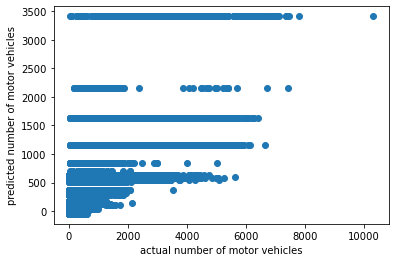

In [26]:
plt.figure()
plt.scatter(y_test, preds_anon)
plt.xlabel('actual number of motor vehicles')
plt.ylabel('predicted number of motor vehicles')
plt.show()

In [27]:
# Smaller clusters.
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
df['cluster'] = kmeans.labels_
#print(df.head())
feas_anon = [f+'_anon' for f in features]

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=feas_anon)
cluster_centers['cluster_num'] = cluster_centers.index
#print(cluster_centers.head())
df_merge = df.merge(cluster_centers, how='left', left_on='cluster', right_on='cluster_num')
new_X = df_merge[feas_anon]
new_y = df_merge['all_motor_vehicles']
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)

lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

preds_anon = lm.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization with 5 clusters):', r2_anon)

R2 Score (With Anonymization with 5 clusters): 0.37875430571516644


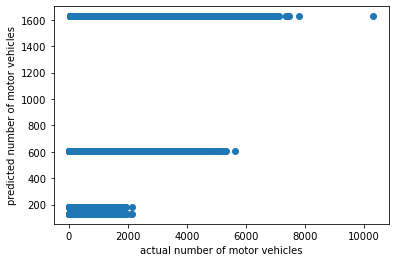

In [28]:
plt.figure()
plt.scatter(y_test, preds_anon)
plt.xlabel('actual number of motor vehicles')
plt.ylabel('predicted number of motor vehicles')
plt.show()

As we increase the number of clusters, the R2 score increases.The 2 scatterplots, show that there is a strong linear relationship with the actual and predicted number of motor vehicles. We see that, as the number of clusters increased, the scatterplot shows a more stronger relationship.